<a href="https://colab.research.google.com/github/TheCoolCodeName/STREDWES-SWELL/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

This Google Colab notebook is designed to process raw Mobi signals that have been previously converted to MATLAB format.

To execute, all subject-specific .mat files must be store in a subfolder named `raw_data`. This subfolder must be located in a top-level folder on your Google Drive, named `STREDWES-SWELL` by default.
Should you wish to designate a different folder for this purpose, you can do so by modifying the value of the `SWELL_KW_DIR` variable below.

Please ensure the aforementioned folder structure is adhered to before proceeding with the execution of this notebook.

This notebook store the results in a `dataset` subfolder of the same top-level Google Drive folder.

For further instructions see `doc/processing.md` in the GitHub repository.

In [ ]:
!git clone https://github.com/ggerardlatek/STREDWES-SWELL
%cd STREDWES-SWELL
!pip install -r requirements.txt

Cloning into 'STREDWES-SWELL'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 67 (delta 21), reused 52 (delta 12), pack-reused 0
Receiving objects: 100% (67/67), 3.42 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Error downloading object: dataset/dataset_swell_processed.pkl (0324120): Smudge error: Error downloading dataset/dataset_swell_processed.pkl (032412081b0215b650d36252abf4cde13e179c8b470320ee3f499e1f1f549bd0): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/STREDWES-SWELL/.git/lfs/logs/20240706T085111.243027053.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: dataset/dataset_swell_processed.pkl: smudge filter lfs failed
You can inspect what was checked out with 'git status'
and retr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTANT** Change the following variable `SWELL_KW_DIR` to match the name of the folder under your Google Drive root that contains the `raw_data` folder with the `.mat` data files converted with the MATLAB scripts.

In [ ]:
SWELL_KW_DIR = "STREDWES-SWELL"

In [ ]:
# Check that the code has been cloned
import os
import sys

def check_environment_cloned(env_directory):
    return os.path.exists(env_directory)

work_dir = "/content/STREDWES-SWELL"

# Replace 'your_env_directory' with the path to your environment directory
env_cloned = check_environment_cloned(work_dir)
print(f'Environment cloned: {env_cloned}')
if not env_cloned:
  sys.exit()

Environment cloned: True


In [ ]:
# Setting data folders paths

swell_kw_path = f'/content/drive/MyDrive/{SWELL_KW_DIR}'
input_data_dir = f'{swell_kw_path}/raw_data'
input_datainfo_dir = 'D - Physiology features (HR_HRV_SCL - final).csv'
tmp_dir = f'{work_dir}/tmp'
out_dir = f'{swell_kw_path}/dataset'


In [ ]:
# Check that the "raw_data" folder is available
# and that all raw datafiles are present

# Check if the data folder exists
if not os.path.exists(input_data_dir):
    print(f"Error: The data folder '{input_data_dir}' does not exist.")
    sys.exit()

# Check if the expected files are present in the data folder
for subject_id in range(1,26):
    file_name = f's{subject_id}_physio_raw.mat'
    file_path = os.path.join(input_data_dir, file_name)
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_name}' is not present in the data folder.")
        sys.exit()


In [ ]:
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:

os.chdir(work_dir)
print('Work_dir:',work_dir)

Work_dir: /content/STREDWES-SWELL


### Create Swell Processed Dataset

In [ ]:
encoding=True
remove_Relax_label=True
label_encoder={'N':0, 'R':0, 'I':1, 'T':1}


Discarded subjects:
- S3, S15, S22, S25: data available just for one class ('Strees' or 'No stress')
- S8 and S11: have '999' in HR signal from datainfo file
- S23: No EDA signal
- S19 and S20: HR signal not usable

In [ ]:
subjects =[10,12,13]

Processing parameters

In [ ]:
fc=2048   # Sampling frequency
fdown=32  # Downsampling frequency
down_factor = fc//fdown

Load `D - Physiology features (HR_HRV_SCL - final).csv`


In [ ]:
df_4_labels = pd.read_csv(os.path.join(input_data_dir, input_datainfo_dir))
df_4_labels['timestamp']=pd.to_datetime(df_4_labels['timestamp'], format='%Y%m%dT%H%M%S%f')

In [ ]:
dataset_swell = pd.DataFrame()

for s in subjects:
    print(f'\nProcessing Raw Data Subject {s}...')
    sub_d = pd.DataFrame()
    s_ECG=s_EDA=s_HR=np.zeros((1,1))
    date_ricreated = np.zeros((1,1), dtype='datetime64[ns]')

    # 1 - REASSEMBLING SIGNAL PARTS (Concatenation of each of the 3 file .mat per subject)
    for c in [1,2,3]:
        print(f'\tAssembling c part [{c}/3] - Downsampling...')
        s_raw_c_part = scipy.io.loadmat(f"{input_data_dir}/s{s}_physio_raw.mat")[f"raw_pp{s}_c{c}"]

        s_ECG_fd_c_part = s_raw_c_part[0][0][0][0][0][7][7][0]   # ECG
        s_EDA_fd_c_part = s_raw_c_part[0][0][0][0][0][7][6][0]   # EDA
        s_HR_fd_c_part = s_raw_c_part[0][0][0][0][0][7][2][0]    # HR

        # 2 - RESAMPLING
        # Downsampling from 2048hz to 32Hz
        s_ECG_fd_c_part = scipy.signal.decimate(s_ECG_fd_c_part[0], down_factor , n=5, ftype='fir').reshape(1,-1)
        s_EDA_fd_c_part = scipy.signal.decimate(s_EDA_fd_c_part[0], down_factor , n=5, ftype='fir').reshape(1,-1)
        s_HR_fd_c_part = scipy.signal.decimate(s_HR_fd_c_part[0], down_factor , n=5, ftype='fir').reshape(1,-1)

        # date_time creation
        start_c_part = f"{s_raw_c_part[0][0][0][0][0][8][0]} {s_raw_c_part[0][0][0][0][0][9][0]}"
        start_c_part = pd.to_datetime(start_c_part, dayfirst=True)
        date_ricreated_c_part=pd.date_range(start_c_part, periods=len(s_ECG_fd_c_part[0]), freq=f"{round((1000/fdown),6)} ms").to_series().to_numpy().reshape((1,-1))

        s_ECG=np.concatenate((s_ECG,s_ECG_fd_c_part),1)
        s_EDA=(np.concatenate((s_EDA,s_EDA_fd_c_part),1))
        s_HR=(np.concatenate((s_HR,s_HR_fd_c_part),1))
        date_ricreated=(np.concatenate((date_ricreated,date_ricreated_c_part),1))

    sub_d['date_time'] = date_ricreated[:,1:].flatten()
    sub_d['id_subject'] = s
    sub_d['ECG'] = s_ECG[:,1:].flatten()
    sub_d['EDA'] = s_EDA[:,1:].flatten()
    sub_d['HR'] = s_HR[:,1:].flatten()

    # 3 - LABELING
    # Label reconstruction from infodata file

    print('\tLabeling...')
    sub_d['label'] = '-'
    sub_d['HR_proc'] = 0
    sub_d['variation_label'] = '0'

    sub_d_proc=df_4_labels[df_4_labels['PP']==f"PP{s}"]
    for i in sub_d_proc.index[:-1]:

            # 4 - DATA CLEANING
            # Remove records if:
            # - There are time gaps longer than 1 minute in datainfo file
            # - HR  in datainfo file have '999'
            # - RMSSD  in datainfo file have '999'

            start= sub_d_proc['timestamp'][i]
            end= sub_d_proc['timestamp'][i+1]
            dhms = (end-start).components
            if (dhms[0] == 0 and dhms[1]==0 and dhms[2]==1 and dhms[3]==0 and sub_d_proc.loc[i,'HR']!=999 and sub_d_proc.loc[i,'RMSSD'] != 999):
                ind=sub_d.loc[sub_d['date_time']>=start].loc[sub_d['date_time']<end].index
                if encoding==True:
                    sub_d.loc[ind,'label'] = label_encoder[sub_d_proc.loc[i,'Condition']]
                    sub_d.loc[ind,'label_original'] = sub_d_proc.loc[i,'Condition']
                else:
                    sub_d.loc[ind,'label'] = sub_d_proc.loc[i,'Condition']
                sub_d.loc[ind,'HR_proc'] = sub_d_proc.loc[i,'HR']
                sub_d.loc[ind,'RMSSD'] = sub_d_proc.loc[i,'RMSSD']
                sub_d.loc[ind,'SCL'] = sub_d_proc.loc[i,'SCL']

    # 5 - REMOVING INVALID LABELS AND RELAX LABEL ('R')
    sub_d = sub_d[sub_d['label'] != '-']
    if remove_Relax_label==True:
        sub_d = sub_d[sub_d['label_original'] != 'R']

    # 6 - FINAL 'timestamp' CREATION
    sample_factor = {'seconds':fdown, 'minutes':fdown*60, 'hours':fdown*3600}
    t = np.linspace(0, len(sub_d)-1, len(sub_d)) / sample_factor['minutes']
    sub_d['timestamp'] = t

    ################################### CONCATENATION (per subject) ####################################
    dataset_swell = pd.concat([dataset_swell, sub_d], ignore_index=True)

# 7 - RESET INDEX (due to time gap discussed in point 4) & IDENTIFICATIION LABEL VARIATION POINT:
print("\n\tFind label variation points...")
dataset_swell.reset_index(inplace=True)

dataset_swell.loc[0,'variation_label'] = '1'
for j in dataset_swell.index[:-1]:
    if dataset_swell.loc[j,'label']!= dataset_swell.loc[j+1,'label']:
        dataset_swell.loc[j+1,'variation_label'] = '1'

print("'PREP_1_labelled_resampled' created")



Processing Raw Data Subject 10...
	Assembling c part [1/3] - Downsampling...
	Assembling c part [2/3] - Downsampling...
	Assembling c part [3/3] - Downsampling...
	Labeling...

Processing Raw Data Subject 12...
	Assembling c part [1/3] - Downsampling...
	Assembling c part [2/3] - Downsampling...
	Assembling c part [3/3] - Downsampling...
	Labeling...

Processing Raw Data Subject 13...
	Assembling c part [1/3] - Downsampling...
	Assembling c part [2/3] - Downsampling...
	Assembling c part [3/3] - Downsampling...
	Labeling...

	Find label variation points...
'PREP_1_labelled_resampled' created


In [ ]:
print('Saving PREP_1_labelled_resampled.pkl')

# 8 - Saving in intermediate folder
if not os.path.exists(tmp_dir):
  os.mkdir(tmp_dir)

with open(f'{tmp_dir}/PREP_1_labelled_resampled.pkl', 'wb') as file:
    pickle.dump(dataset_swell, file)
print('...Done.')

dataset_swell

Saving PREP_1_labelled_resampled.pkl
...Done.


,index,date_time,id_subject,ECG,EDA,HR,label,HR_proc,variation_label,label_original,RMSSD,SCL,timestamp
0,0,2012-10-08 13:20:00.000000,10,29.665824,101.194149,71.526878,0,68,1,N,0.047916,106.215068,0.000000
1,1,2012-10-08 13:20:00.031250,10,34.501411,101.300602,71.485169,0,68,0,N,0.047916,106.215068,0.000521
2,2,2012-10-08 13:20:00.062500,10,25.754256,101.412659,71.440169,0,68,0,N,0.047916,106.215068,0.001042
3,3,2012-10-08 13:20:00.093750,10,20.742519,101.156361,71.395165,0,68,0,N,0.047916,106.215068,0.001563
4,4,2012-10-08 13:20:00.125000,10,13.157802,101.601963,71.350165,0,68,0,N,0.047916,106.215068,0.002083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,316795,2012-10-10 12:05:59.843750,13,12.099362,212.295784,62.993768,1,67,0,I,0.093694,175.309690,49.997396
316796,316796,2012-10-10 12:05:59.875000,13,13.726979,212.329163,62.979292,1,67,0,I,0.093694,175.309690,49.997917
316797,316797,2012-10-10 12:05:59.906250,13,37.242128,212.208527,62.964817,1,67,0,I,0.093694,175.309690,49.998438
316798,316798,2012-10-10 12:05:59.937500,13,38.286622,212.165840,62.950342,1,67,0,I,0.093694,175.309690,49.998958


Load labeled dataset


#### Plot signals of single subjects


In [ ]:
def plot_signals(dataset, sub, features, title):

    df=dataset[dataset['id_subject']==sub]

    color_labels = df.label_original.unique() # ['R' 'N' 'T' 'I']
    dict_labels = {'R':'Relax phase (R)', 'N': 'Neutral (N)', 'I': 'Interruption (I)', 'T': 'Time Pressure (T)'}

    # List of RGB triplets
    rgb_values = sns.color_palette("Set2", len(color_labels))
    # Map label to RGB
    color_map = dict(zip(color_labels, rgb_values))  #{'R': (0.4, 0.7607843137254902, 0.6470588235294118), 'N'...}

    _, axs = plt.subplots(len(features), figsize=(18,13))
    for i,feature in enumerate(features):
        grouped = df.groupby('label_original')

        for key, group in grouped:
            group.plot(ax=axs[i], x='timestamp', y=feature, label=dict_labels[key], color=color_map[key])

        if i==0:
            axs[i].set_title(f'Subject S{sub}: {title}')
        axs[i].set_ylabel(feature,fontsize='large')
        axs[i].set_xlabel('')
        axs[i].legend(loc='best', prop={'size': 10}, markerscale =20)
        if i==len(features)-1:
            axs[i].set_xlabel('tempo[minuti]')

    plt.show()

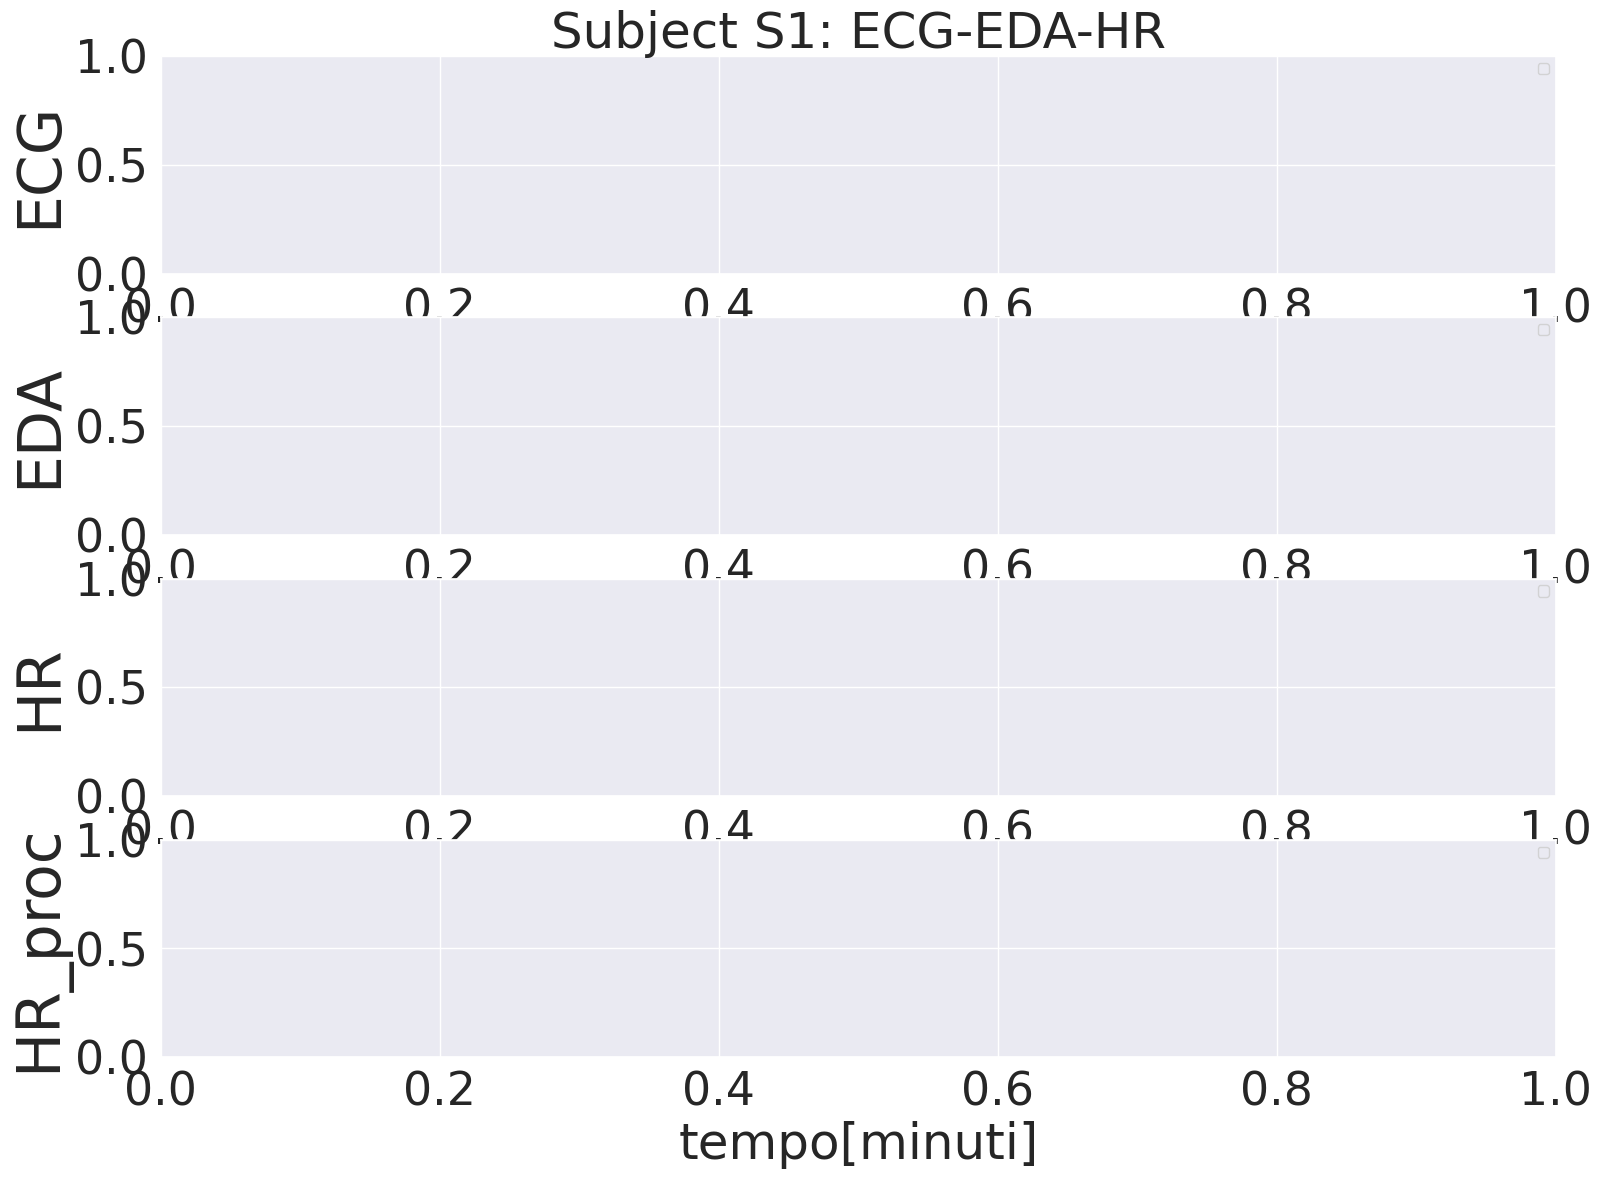

In [ ]:
title='ECG-EDA-HR'
plot_signals(dataset_swell, sub=1, features=['ECG', 'EDA', 'HR', 'HR_proc'], title=title)

#### Plot signals of multiple subjects

In [ ]:
def plot_series_sub(subjs):
    for sub in subjs:

        subj_data=dataset_swell[dataset_swell['id_subject']==sub]

        #Ricavo gli indici di annotation (quando variation_label=1) (con annotation troppo confusionario)
        #subj_data['variation_label'][0] = '1' #aggiungo annotazione anche al primo campione
        #annotation_ind=subj_data[subj_data['variation_label']=='1'].index

        plt.subplot(311)
        plt.plot(subj_data['timestamp'], subj_data['ECG'], label = f'S{sub}')
        #plt.plot(subj_data['timestamp'][annotation_ind], subj_data['ECG'][annotation_ind],'x', color='red', markersize=12)
        plt.legend(loc='upper left')
        plt.ylabel('ECG')
        plt.xlabel('tempo [minuti]')

        plt.subplot(312)
        plt.plot(subj_data['timestamp'], subj_data['EDA'], label = f'S{sub}')
        #plt.plot(subj_data['timestamp'][annotation_ind], subj_data['EDA'][annotation_ind],'x', color='red', markersize=12)
        plt.legend(loc='upper left')
        plt.ylabel('EDA')
        plt.xlabel('tempo [minuti]')

        plt.subplot(313)
        plt.plot(subj_data['timestamp'], subj_data['HR'], label = f'S{sub}')
        #plt.plot(subj_data['timestamp'][annotation_ind], subj_data['HR'][annotation_ind],'x', color='red', markersize=12)
        plt.legend(loc='upper left')
        plt.ylabel('HR')
        plt.xlabel('tempo [minuti]')

    fig = plt.gcf()
    fig.set_size_inches(18, 13)
    plt.show()

For comparison we can also plot the timeseries signals of a set of subjects.

In the example below we plot the signals of Subjects 1, 2 and 4.

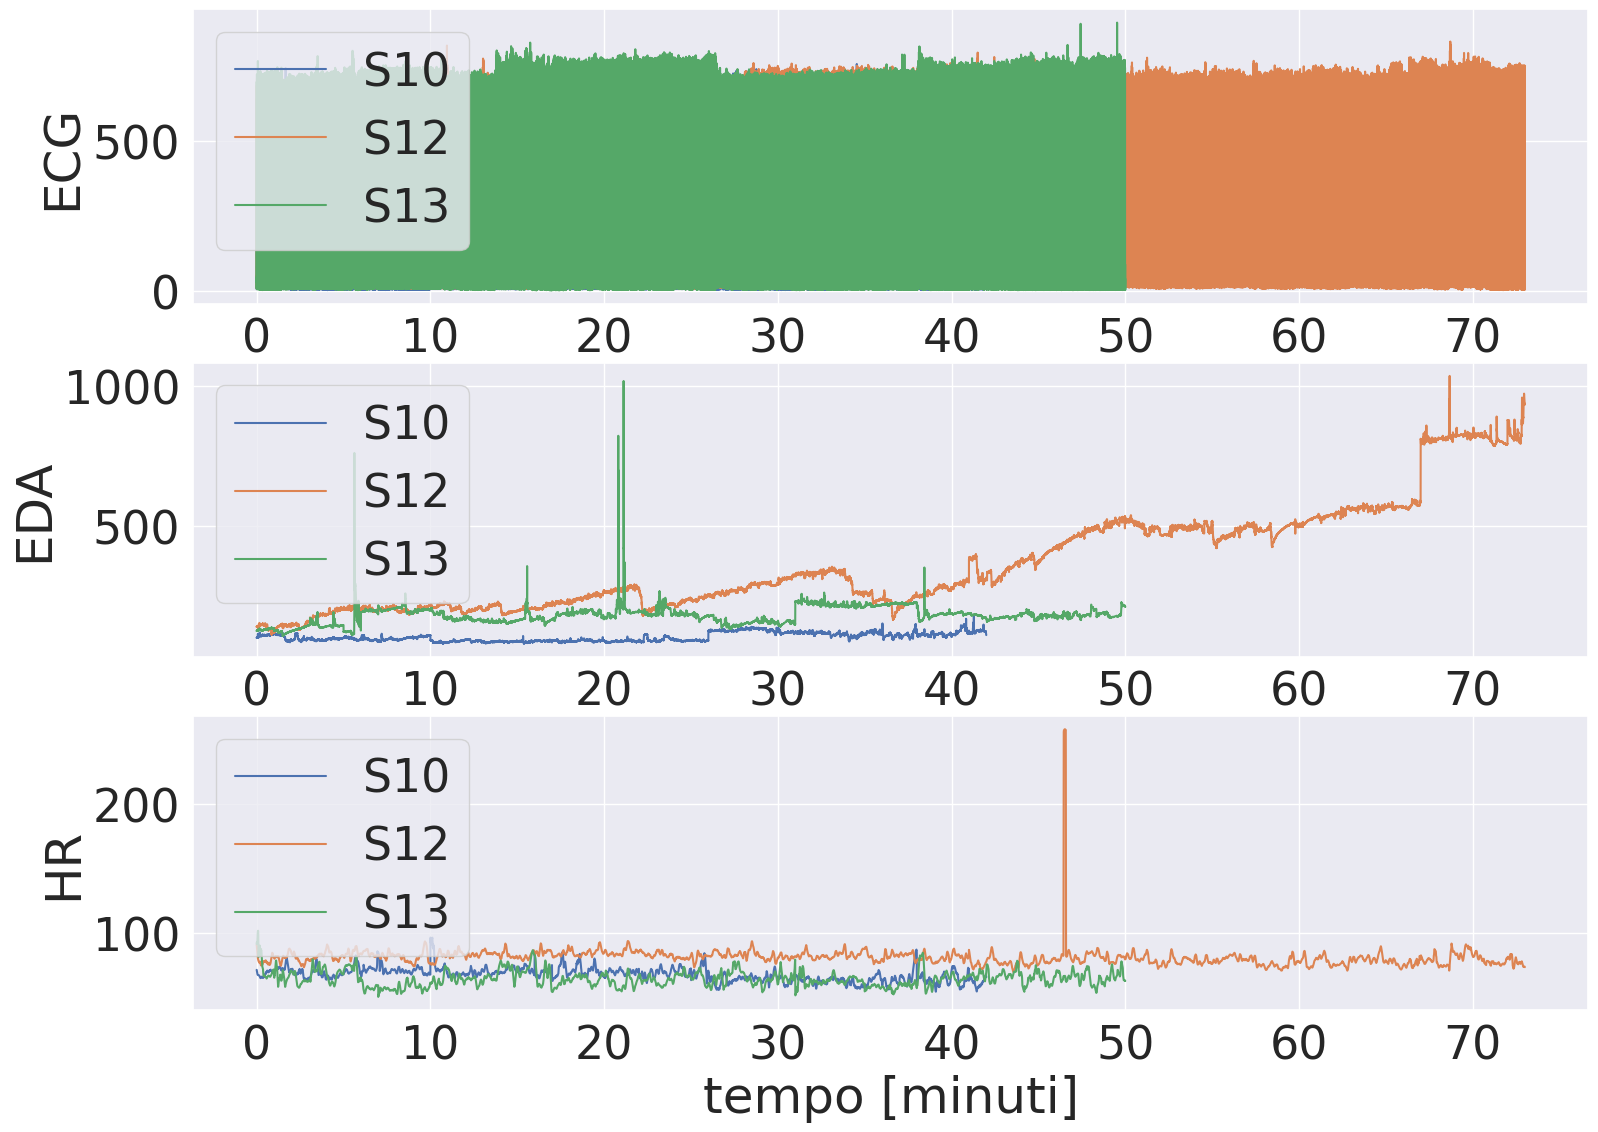

In [ ]:
plot_series_sub(subjs=[10,12,13])

### OUTLIER REMOVAL


In [ ]:
df = dataset_swell
features = ['ECG', 'EDA', 'HR']

# Removing Outliers (per subject)
imp = SimpleImputer(strategy="mean")
for f in features:
    for sub in subjects:
        data_s = df[df.id_subject == sub]
        percentile_99 = data_s[f].quantile(0.984)

        data_s.loc[data_s[f]>=percentile_99, f] = np.nan
        data_s.loc[data_s[f]<=0, f] = np.nan

        ind = df[df.id_subject == sub][f].index
        data=np.reshape(data_s[f].to_numpy(),(-1, 1))
        df.loc[ind, f] = imp.fit_transform(data)


# Saving in tmp folder
print("Saving 'PREP_2_outlier_removed.pkl'...")
with open(f'{tmp_dir}/PREP_2_outlier_removed.pkl', 'wb') as file:
    pickle.dump(df, file)
print('...Done.')

df

Saving 'PREP_2_outlier_removed.pkl'...
...Done.


,index,date_time,id_subject,ECG,EDA,HR,label,HR_proc,variation_label,label_original,RMSSD,SCL,timestamp
0,0,2012-10-08 13:20:00.000000,10,29.665824,101.194149,71.526878,0,68,1,N,0.047916,106.215068,0.000000
1,1,2012-10-08 13:20:00.031250,10,34.501411,101.300602,71.485169,0,68,0,N,0.047916,106.215068,0.000521
2,2,2012-10-08 13:20:00.062500,10,25.754256,101.412659,71.440169,0,68,0,N,0.047916,106.215068,0.001042
3,3,2012-10-08 13:20:00.093750,10,20.742519,101.156361,71.395165,0,68,0,N,0.047916,106.215068,0.001563
4,4,2012-10-08 13:20:00.125000,10,13.157802,101.601963,71.350165,0,68,0,N,0.047916,106.215068,0.002083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,316795,2012-10-10 12:05:59.843750,13,12.099362,212.295784,62.993768,1,67,0,I,0.093694,175.309690,49.997396
316796,316796,2012-10-10 12:05:59.875000,13,13.726979,212.329163,62.979292,1,67,0,I,0.093694,175.309690,49.997917
316797,316797,2012-10-10 12:05:59.906250,13,37.242128,212.208527,62.964817,1,67,0,I,0.093694,175.309690,49.998438
316798,316798,2012-10-10 12:05:59.937500,13,38.286622,212.165840,62.950342,1,67,0,I,0.093694,175.309690,49.998958


In [ ]:
# VIOLIN PLOT (violin_chart stratified for subject)
def violin(db, features):
    for feature in features:
        plt.rcParams['figure.dpi'] = 100
        sns.set(font_scale=3)
        fig, axes = plt.subplots(figsize=(38,11))

        # Find the order
        my_order = db.groupby('id_subject')[feature].median().sort_values().index
        sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)

        axes.set_title(feature, fontsize='x-large')
        axes.set_xlabel('value')

        axes.yaxis.grid(True)
    plt.show()

#### Not normalized signal distribution


<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)
<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)
<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)


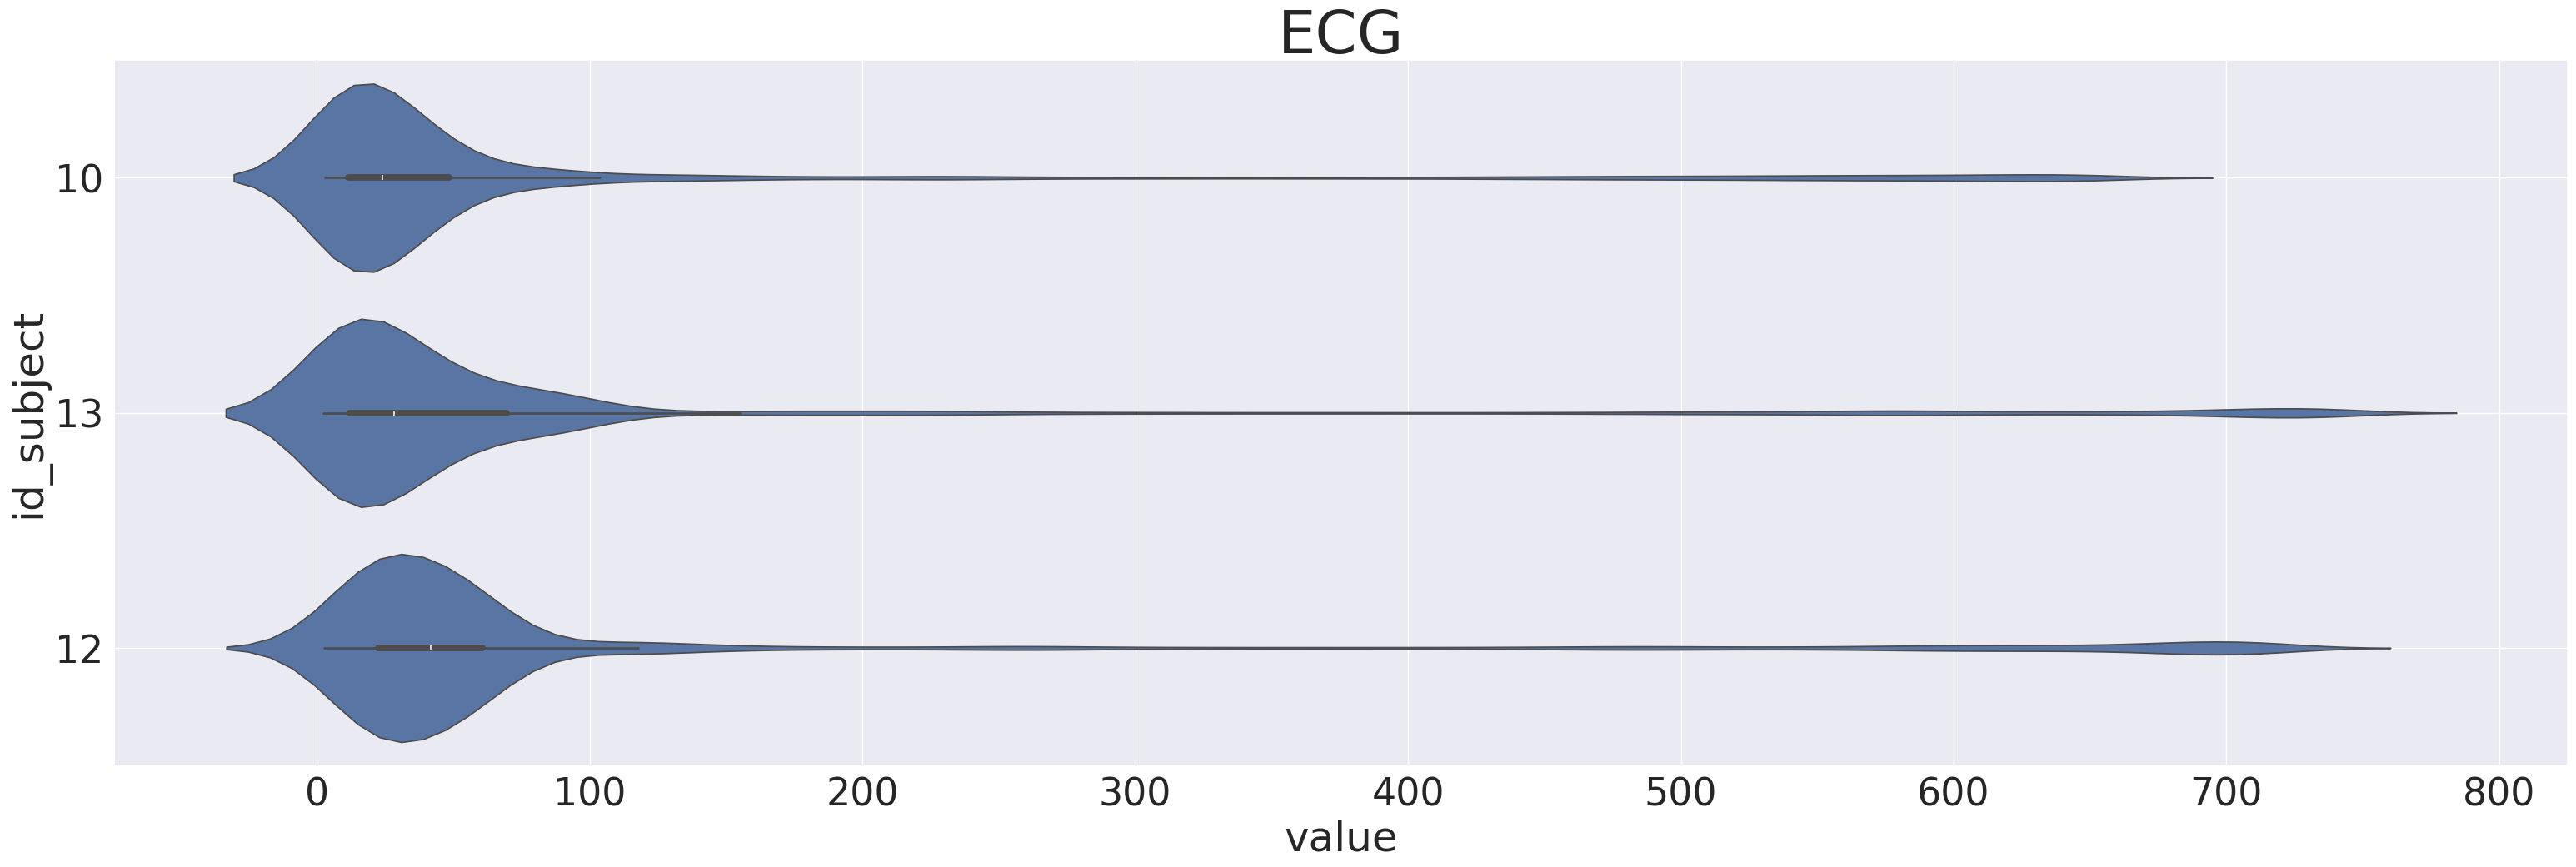

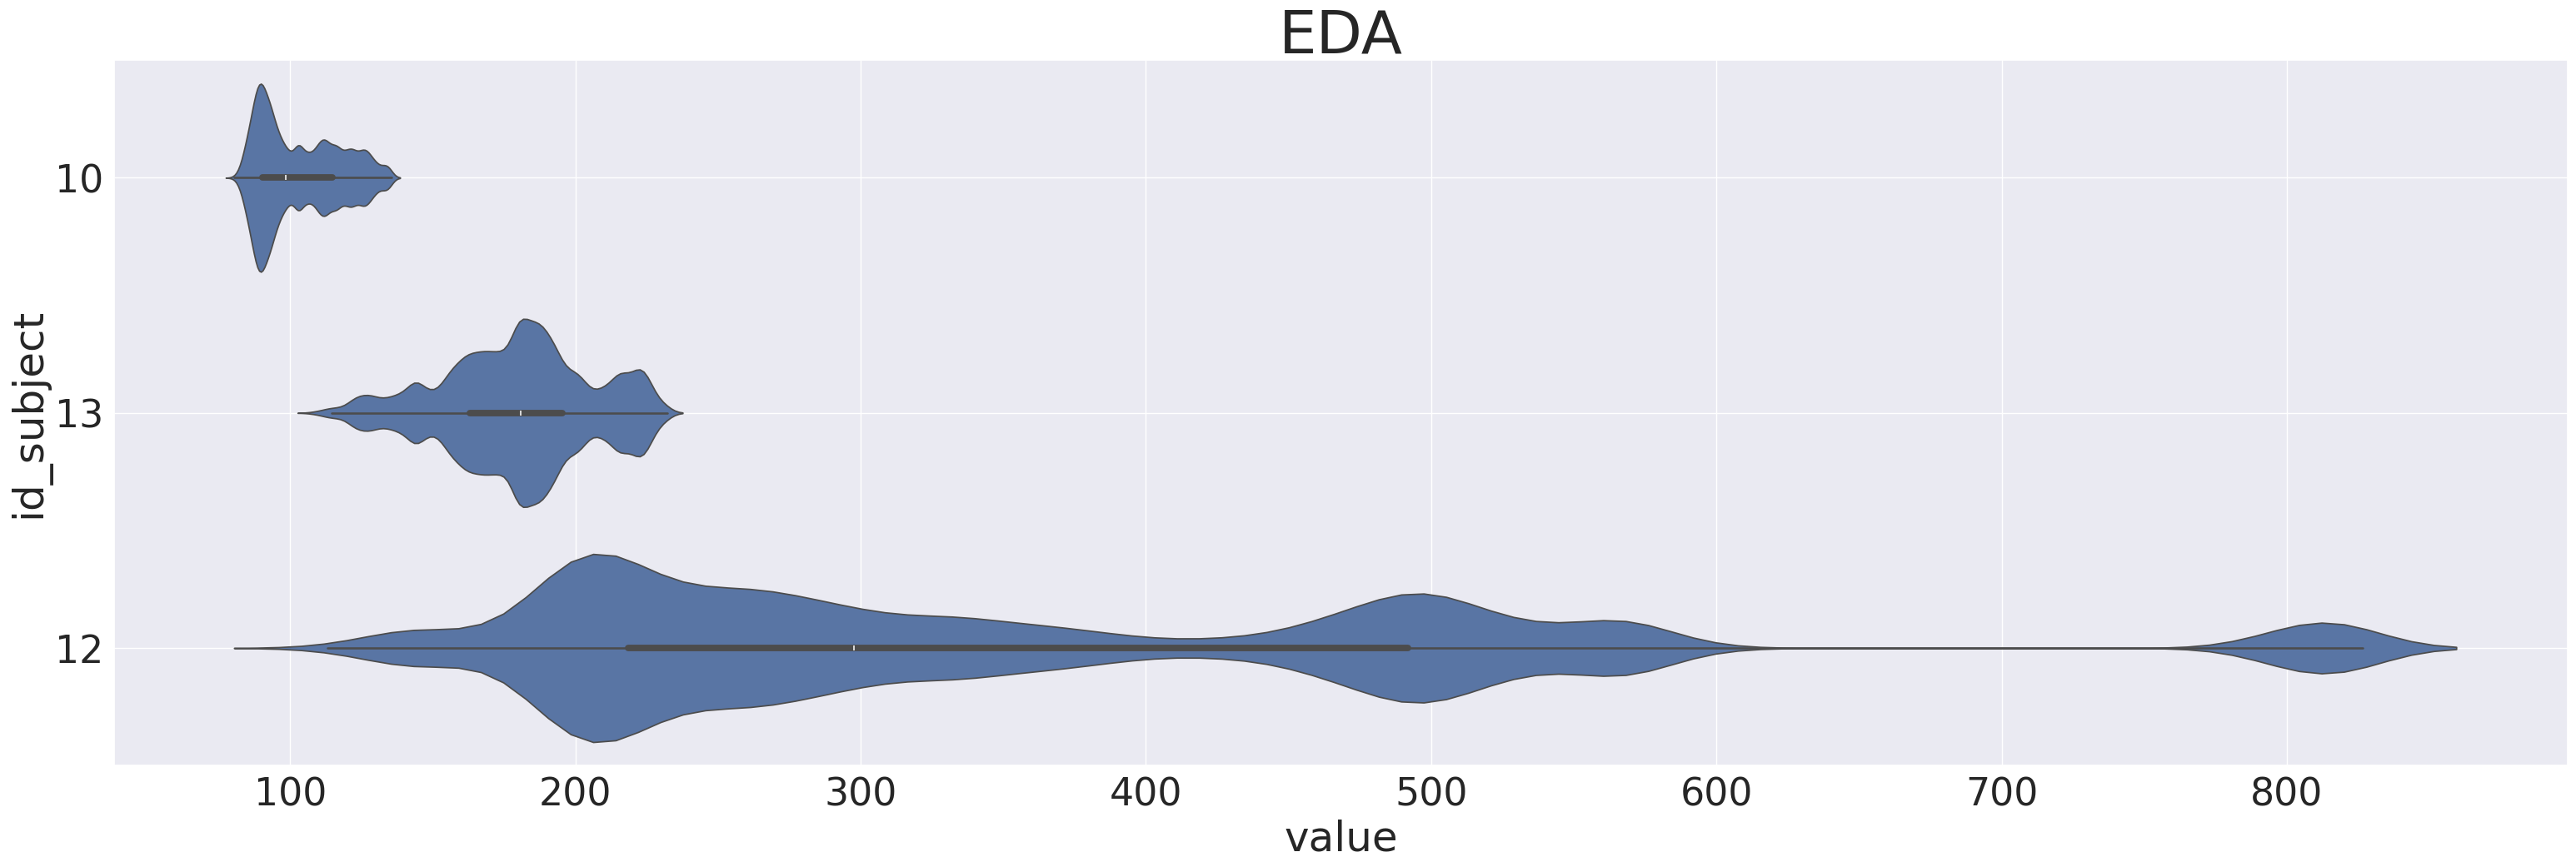

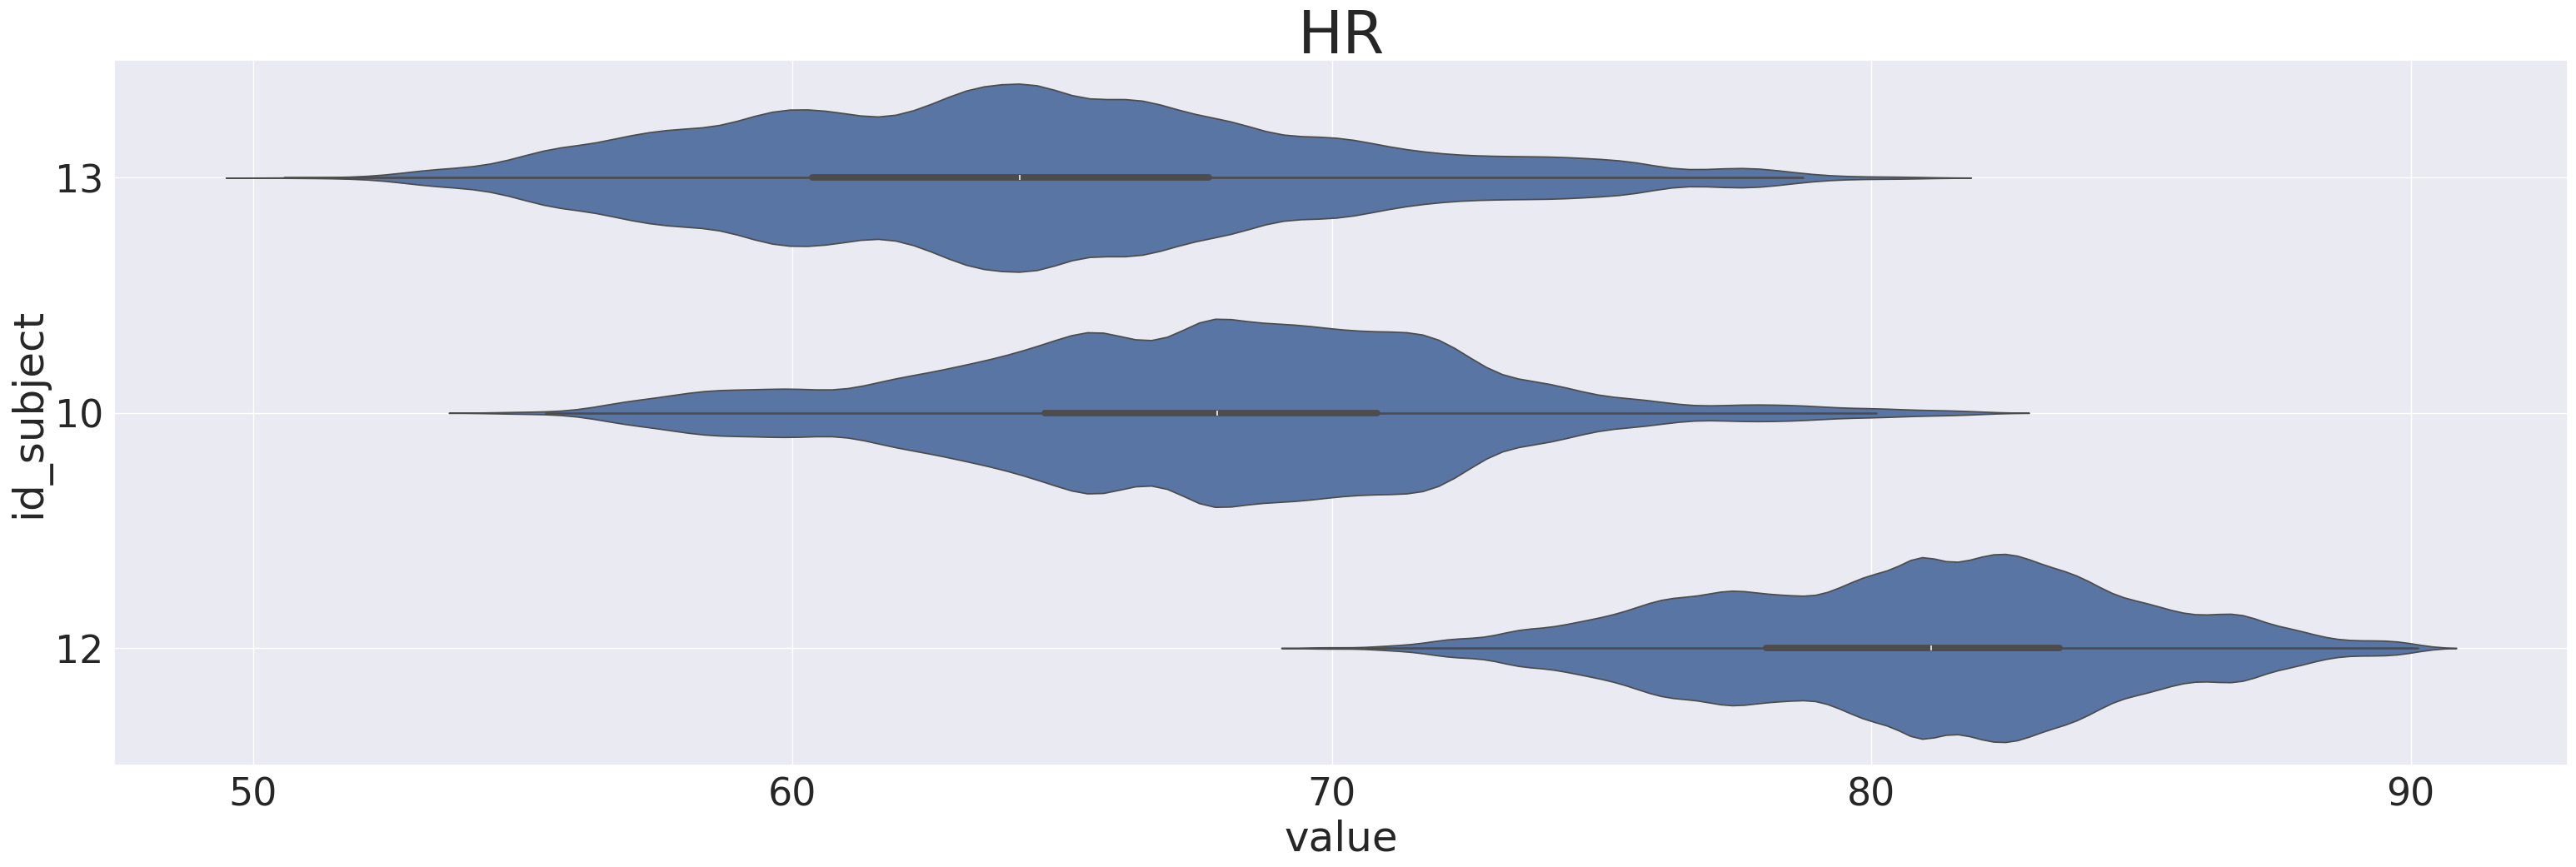

In [ ]:
violin(df, features)

### NORMALIZATION (RobustScaler) and CLIPPING

#### Normalization

In [ ]:
for feature in features:
    for sub in subjects:
        data=df[df.id_subject == sub][feature]
        data=np.reshape(data.to_numpy(),(-1, 1))
        ind=df[df.id_subject == sub][feature].index
        df.loc[ind,feature] = RobustScaler().fit_transform(data)
print('Done.')

Done.


#### Normalized Signal Distribution

<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)
<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)
<ipython-input-39-1a01e715f345>:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=feature, y= 'id_subject', data=db, orient='h',ax=axes, scale = "width", order = my_order)


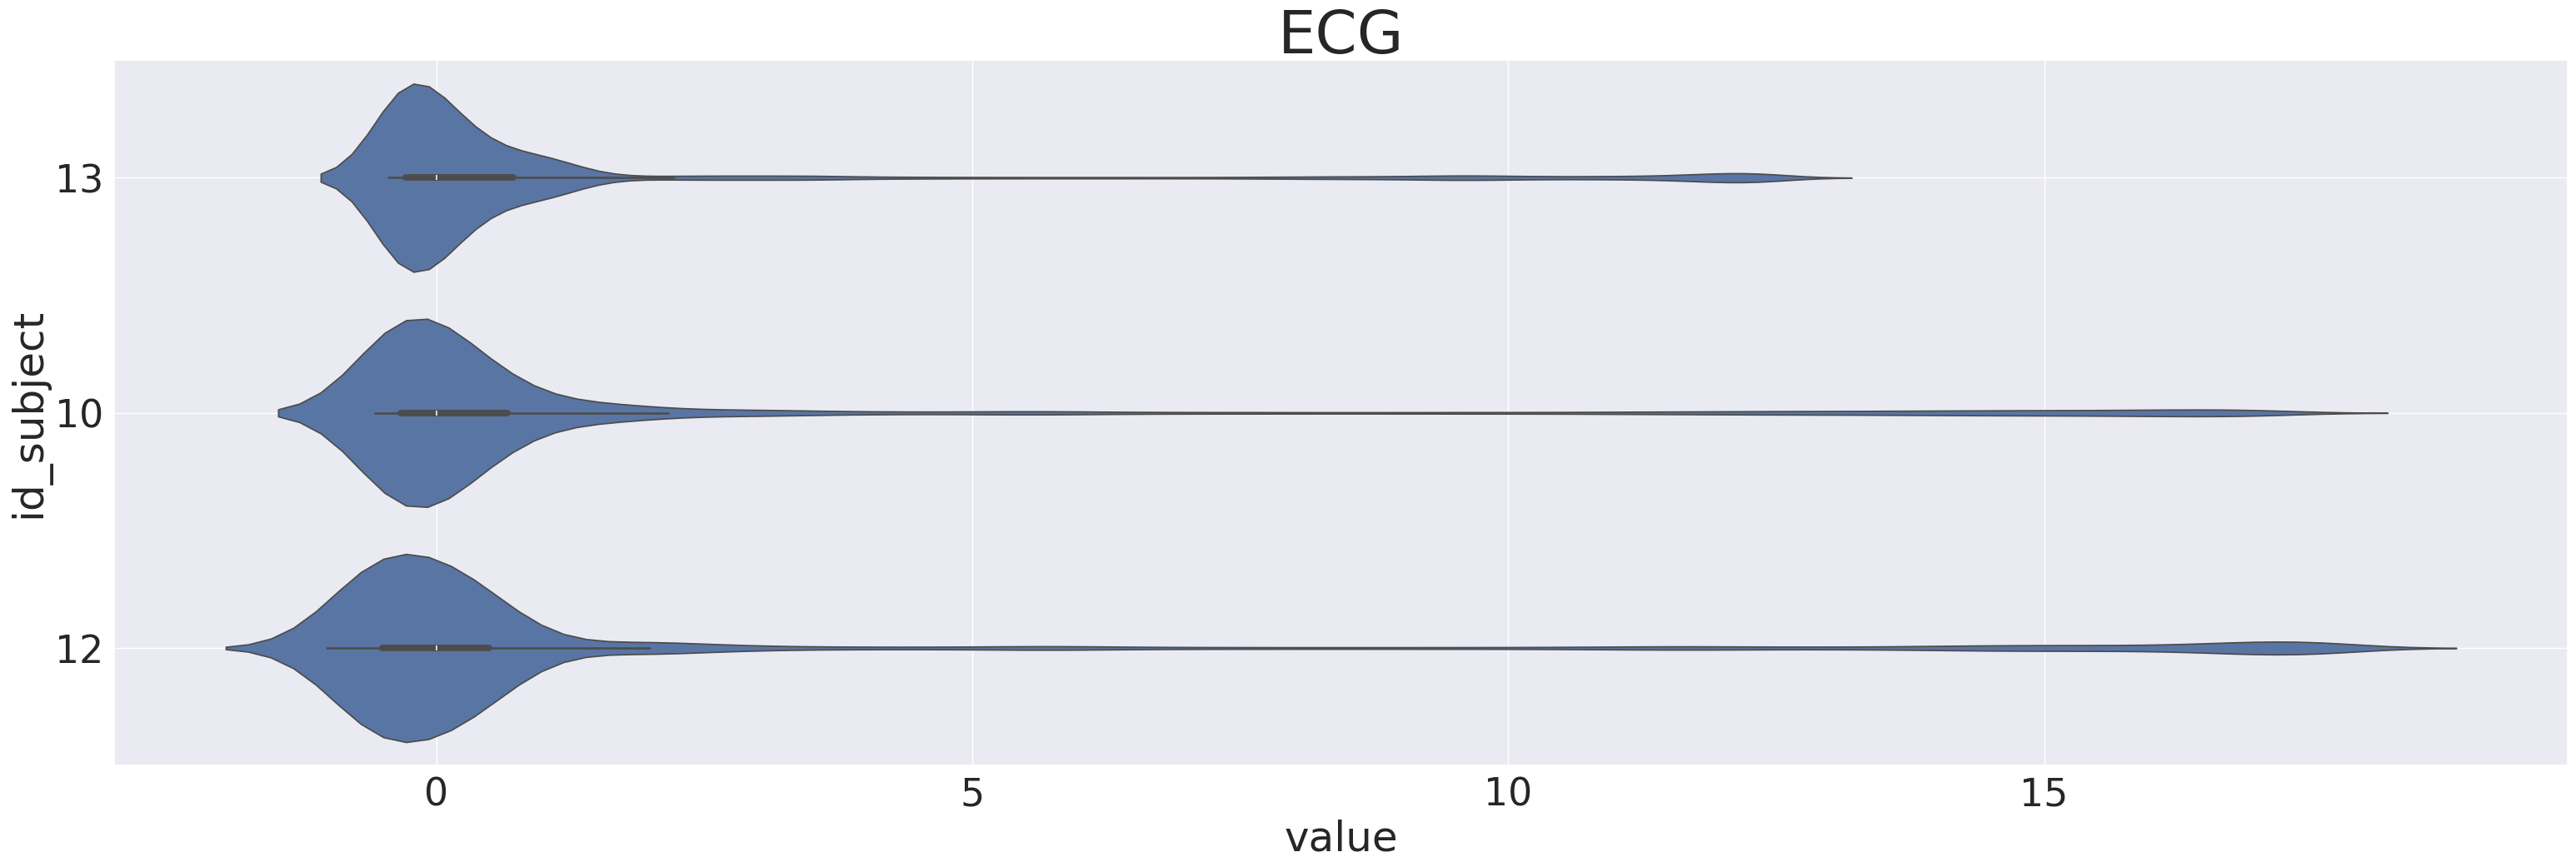

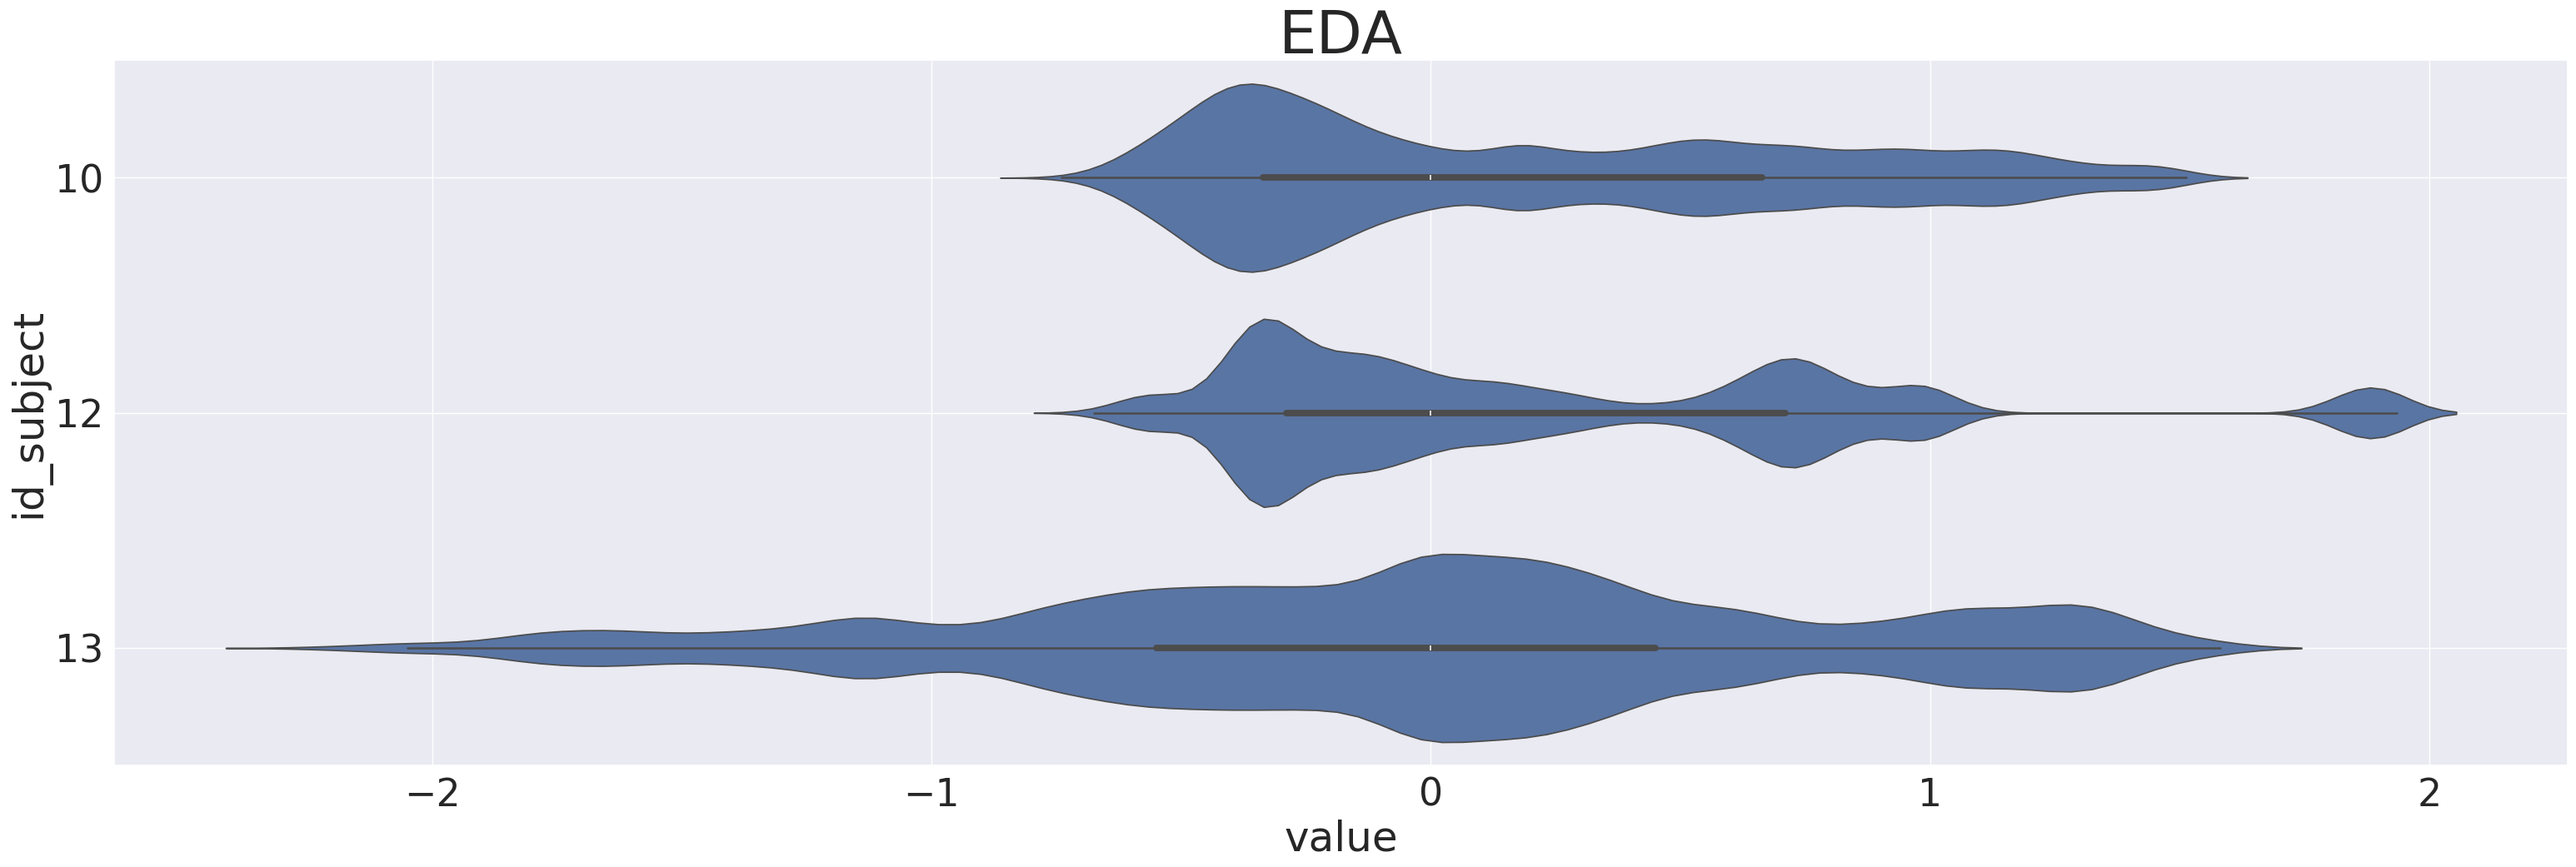

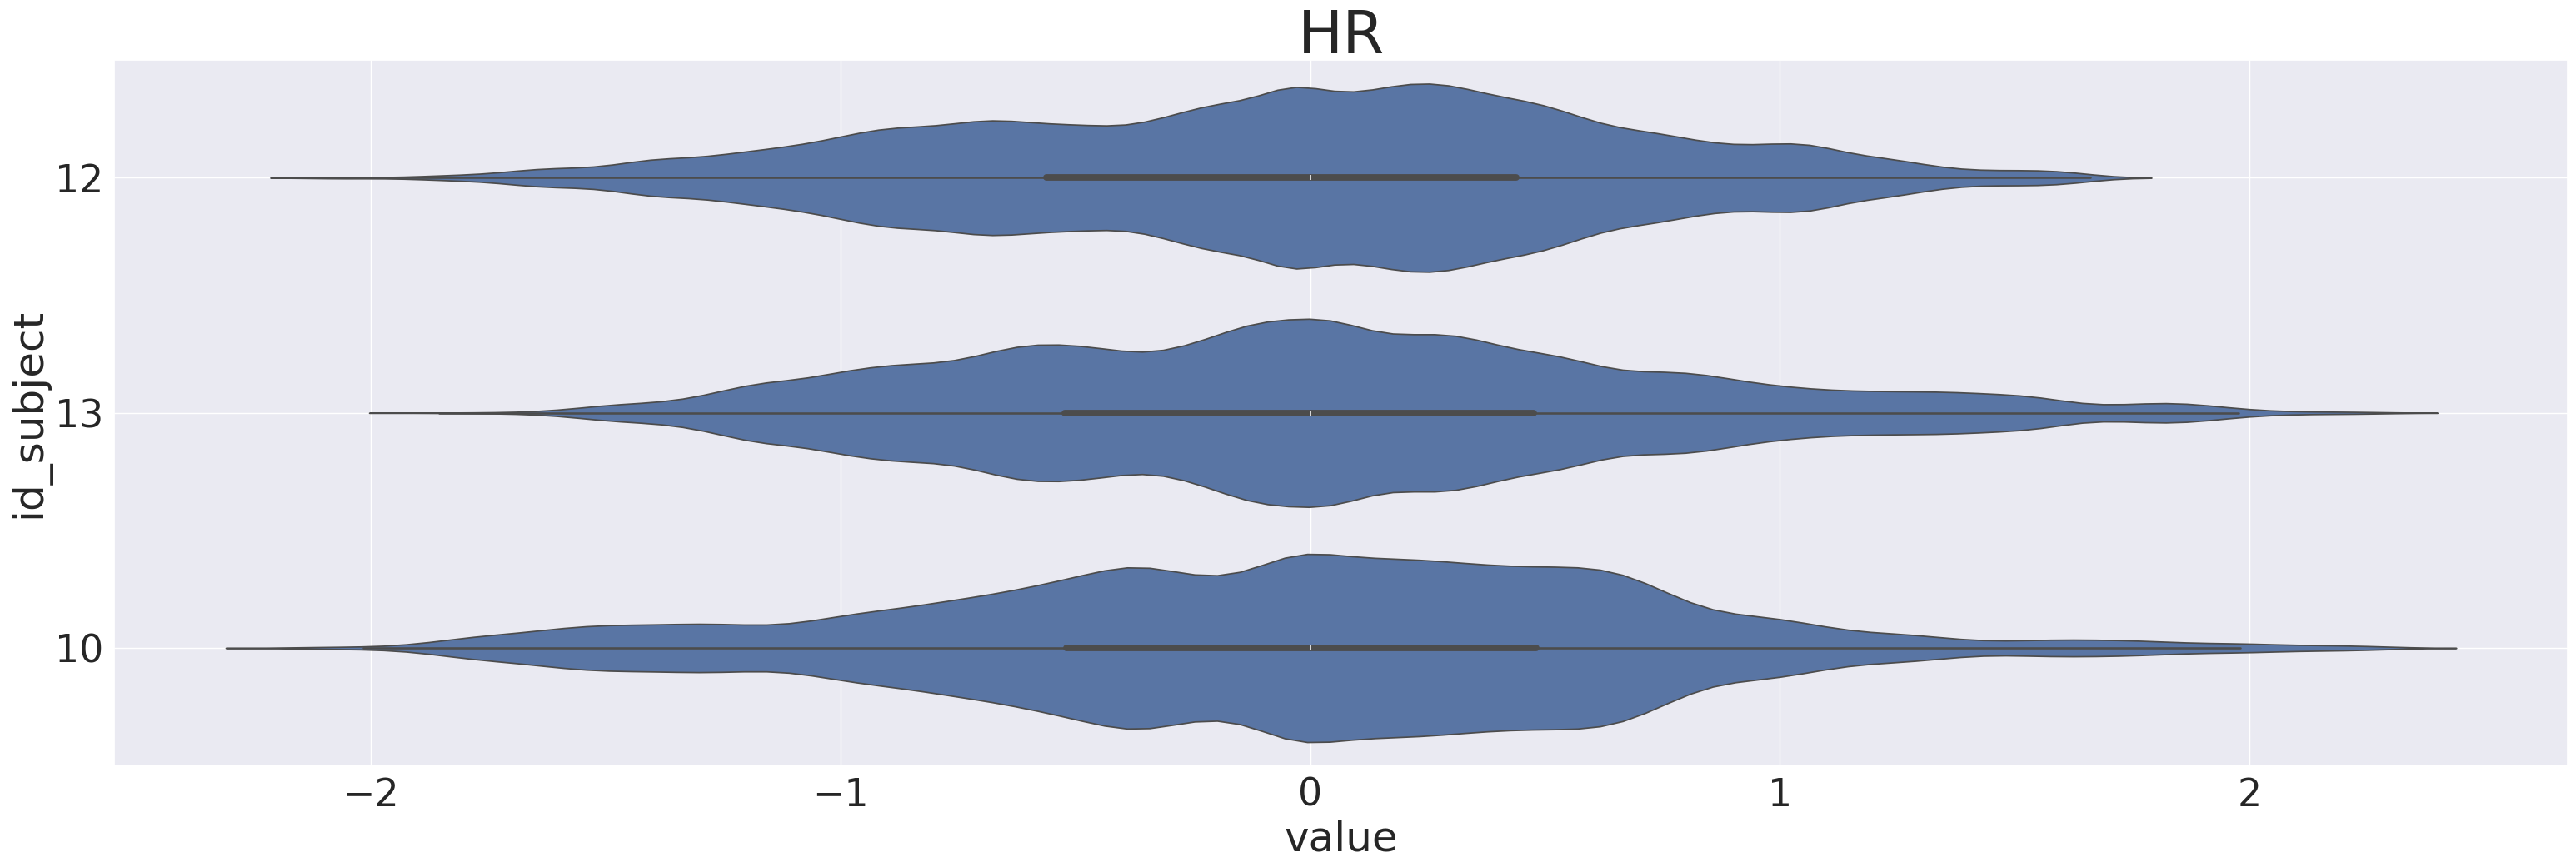

TypeError: '<=' not supported between instances of 'int' and 'Timestamp'

In [ ]:
violin(df, features)

# Check
print(np.min(df))
print(np.max(df))

#### Clipping

This is needed for proper GAF image transformation

In [ ]:
transformer = FunctionTransformer(np.clip, validate=True, kw_args={'a_min':-4,'a_max':4})
data=df.loc[:,features].to_numpy()
df.loc[:,features]=transformer.fit_transform(data)/4.00001
print('Done.')

Done.


In [ ]:
print("Saving the final 'dataset_swell_processed.pkl' in output dir...")

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

with open(f"{out_dir}/dataset_swell_processed.pkl", 'wb') as file:
    pickle.dump(df, file)
print('...Done.')

Saving the final 'dataset_swell_processed.pkl' in output dir...
...Done.


#### Normalized and clipped signal distributions

In [ ]:
violin(df, features)

# Check
print(np.min(df))
print(np.max(df))

#### Signals distributions of all subjects


In [ ]:
# VIOLIN PLOT PER LABEL (violin_chart stratified for label)
def violin_1(db, features):
    for feature in features:
        plt.rcParams['figure.dpi'] = 100
        sns.set(font_scale=3)
        fig, axes = plt.subplots(figsize=(38,11))
        my_order = db.groupby('label_original')[feature].median().sort_values().index
        sns.violinplot(x=feature, y= 'label_original', data=db, orient='h',ax=axes, scale = "width")  #, inner="stick" , order = my_order
        axes.set_title(feature, fontsize='x-large')
        axes.set_xlabel('value')
        axes.yaxis.grid(True)
    plt.show()

violin_1(df, features)


#### Signals distribution per subject per label

In [ ]:
# VIOLIN PLOT PER LABEL (violin_chart stratified for label)
def violin_2(db, subjects, feature):
    plt.rcParams['figure.dpi'] = 100
    sns.set(font_scale=1)
    fig = plt.figure(figsize=(15,18))
    fig.subplots_adjust(hspace=0.4, wspace=0.25)
    fig.suptitle(feature, fontsize=20)

    for i,sub in enumerate(subjects):
        axs=fig.add_subplot(5,4,i+1)
        db_s = db[db['id_subject']==sub]

        my_order = db_s.groupby('label_original')[feature].median().sort_values().index
        sns.violinplot(x=feature, y= 'label_original', data=db_s, orient='h', ax=axs, scale = "width") #, inner="stick", order = my_order

        axs.set_title(sub)#, fontsize='x-large')
        axs.set_xlabel('')
        axs.yaxis.grid(True)
    plt.show()

for feature in features:
    violin_2(df, subjects, feature)


### Labels distribution

#### Label Distribution (Binary classification) for all subjects

In [ ]:
distr = df.label.to_numpy()
unique, counts = np.unique(distr, return_counts=True)

num = [f'Label 0 =  {round((counts[0]/(counts[0]+counts[1]))*100,1)}%\n Neutral (N)',
       f'Label 1 =  {round((counts[1]/(counts[0]+counts[1]))*100,1)}%\n Interruption (I) + Time Pressure (T)']

plt.figure(figsize=(8,4))
plt.rcParams.update({'font.size': 9})
plt.title('Label distribution for binary classification')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.bar(num, counts, color=('royalblue','salmon'))
plt.show()

#### Per subject label distribution


In [ ]:
from matplotlib.ticker import FuncFormatter
def hundreds(x, pos):
    return '%1.0fK' % (x*1e-3)
formatter = FuncFormatter(hundreds)

def labels_distribution(df, subjects):
    plt.rcParams['figure.dpi'] = 100
    sns.set(font_scale=1)
    fig = plt.figure(figsize=(18,21))
    fig.subplots_adjust(hspace=0.4, wspace=0.5)
    fig.suptitle('Label distribution per Subject (Binary classification)\n Label 0: No Stress (Neutral)\n Label 1: Stress (Interruption and Time pressure)', fontsize=25)

    for i,sub in enumerate(subjects):
        axs=fig.add_subplot(4,4,i+1)
        df_s = df[df['id_subject']==sub]

        distr = df_s.label.to_numpy()
        unique, counts = np.unique(distr, return_counts=True)
        num = [f'Label 0 :{round((counts[0]/(counts[0]+counts[1]))*100,1)}%\n (N)',
               f'Label 1 :{round((counts[1]/(counts[0]+counts[1]))*100,1)}%\n (I & T)']
        plt.bar(num, counts, color=('royalblue','salmon'))

        axs.set_title(f'S{sub}')#, fontsize='x-large')
        axs.set_xlabel('')
        axs.yaxis.set_major_formatter(formatter)
        axs.set_ylabel('#Samples')
        axs.yaxis.grid(True)
    plt.show()

labels_distribution(df, subjects)